In [1]:
%run setup.ipynb

Path setup complete.


# Mathematical model 

# Solvers and Schemes

There are multiple solvers which solve a problem with respect to at least one variable between saturation and pressure and numerical schemes which solve the whole pressure plus saturation problem. 

Solvers: 
- Implicit Pressure solver (IMP), 
- Implicit Saturation Solver (IMS)  
- Explicit Saturation Solver (ES)
- Fully Implicit: Solve pressure and saturation simultaeneously

Schemes: 
- IMPES: Implicit pressure solver + Explicit Saturation solver 
- IMPIMS: Implicit Pressure solver + Implicit Saturation solver 
- SOLSS: Based on Fully Implicit solver 

## Set up initial problem

In [2]:
import numpy as np
import yads.mesh as ym
from yads.wells import Well


In [3]:
# Define grid
grid = ym.two_D.create_2d_cartesian(Lx=21, Ly=5, Nx=21, Ny=5)

In [4]:
# Properties 
# Porosity
phi = np.full(grid.nb_cells, 0.2)
# Diffusion coefficient (i.e Permeability)
K = np.full(grid.nb_cells, 100.0e-15)
# viscosity
mu_w = 0.571e-3
mu_g = 0.0285e-3
# Relative permeability model: only 'cross' (kr(s) = s) and 'quadratic' (kr(s) = s**2) are supported 
kr_model = "quadratic"

In [5]:
# BOUNDARY CONDITIONS #
# Pressure
# Small pressure gradient from left to right
Pb = {"left": 110.0e5,  "right": 100.0e5}
# Saturation
# Inject gaz from left to right through Dirichlet boundary conditions
Sb_d = {"left": 1.0, "right": 0.0}
# No Neumann so we create a dict of None
Sb_n = {"left": None, "right": None}
Sb_dict = {"Dirichlet": Sb_d, "Neumann": Sb_n}

In [6]:
from yads.numerics.physics import calculate_transmissivity
# Compute face transmitivity based on mesh geometry and permeability
T = calculate_transmissivity(grid=grid, K=K)

In [7]:
from yads.numerics.solvers import solss_solver, explicit_saturation_solver, implicit_pressure_solver, implicit_saturation_solver

In [8]:
import matplotlib.pyplot as plt

### IMP: Implicit pressure solver 
Solve the pressure problem. In the context of incompressible two-phase flow in porous medium model, pressure behaves in an elliptic linear fashion way. Therefore, solving the pressure problem requires to solve a linear system of equation and the resulting implicit pressure is just a linear approximation between boundary conditions (well can be seen as an inside domain boundary condition, inner condition? )

In [9]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# Pressure initialization: Initial pressure guess, does not matter too much 
P = np.full(grid.nb_cells, 100.0e5)

Pimp = implicit_pressure_solver(
                        grid=grid, 
                        K=K,
                        T=T, 
                        P=P,
                        S=S,
                        Pb=Pb,
                        Sb_dict=Sb_dict, 
                        mu_g=mu_g,
                        mu_w=mu_w,
                        wells=[],
                        kr_model=kr_model
                    )

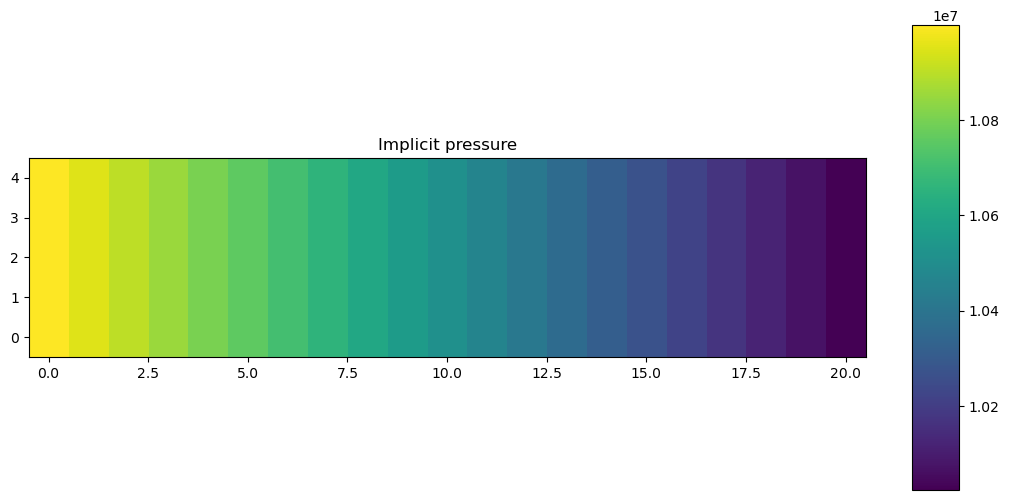

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
im = ax1.imshow(Pimp.reshape(21, 5).T)
ax1.invert_yaxis()
ax1.set_title("Implicit pressure")
plt.colorbar(im, ax=ax1, aspect=10, fraction=0.05)
plt.show()

### ES: Explicit Saturation solver (Not up to date need good refactoring)

The main non-linearities arise through the saturation as it behave in a non-linear hyperbolic fashion.
Saturation can be updated explictly through the Explicit Saturation solver. This solver is conditionally stable and therefore subject to CFL condition. 

In [11]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# Pressure initialization: Initial pressure guess, does matter a lot ! 
P = np.full(grid.nb_cells, 100.0e5)
# timestep in seconds 
dt = 1.
S_exp, F, F_well = explicit_saturation_solver(
                        grid=grid, 
                        K=K,
                        phi=phi, 
                        T=T, 
                        P=P,
                        S=S,
                        Pb=Pb,
                        Sb_dict=Sb_dict,
                        dt=dt,
                        mu_o=mu_g,
                        mu_w=mu_w,
                        wells=[],
                    )

The resulting explicit saturation only takes into account the boundary condition in pressure to compute the flows. Therefore we end up with a zeros everywhere inside the domain except at the left boundary.

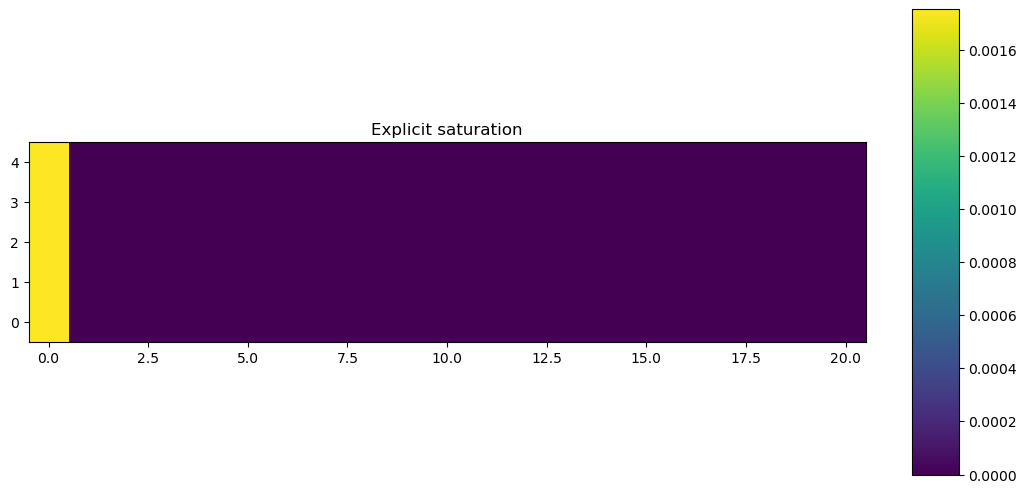

In [12]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
im = ax1.imshow(S_exp.reshape(21, 5).T)
ax1.invert_yaxis()
ax1.set_title("Explicit saturation")
plt.colorbar(im, ax=ax1, aspect=10, fraction=0.05)
plt.show()

In [13]:
from yads.numerics.numerical_tests import cfl_condition
from yads.physics.fractional_flow import dfw_dsw
cfl, _ = cfl_condition(grid=grid, 
              phi=phi, 
              Pb=Pb,
              F=F, 
              F_well=F_well, 
              dfw=dfw_dsw, 
              mu_o=mu_g, 
              mu_w=mu_w, 
              wells=[])

In [14]:
print(f"Max timestep allowed by CFL {cfl:.2f} seconds")

Max timestep allowed by CFL 28.50 seconds


## IMPES
Now we can run IMPES scheme using IMP and ES

In [15]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# Pressure initialization: Initial pressure guess, does not matter too much 
P = np.full(grid.nb_cells, 100.0e5)

Pimp = implicit_pressure_solver(
                        grid=grid, 
                        K=K,
                        T=T, 
                        P=P,
                        S=S,
                        Pb=Pb,
                        Sb_dict=Sb_dict, 
                        mu_g=mu_g,
                        mu_w=mu_w,
                        wells=[],
                        kr_model=kr_model
                    )

We use the implicit pressure as pressure field for the explict saturation update 

In [16]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# timestep in seconds 
dt = 1.
S_exp, F, F_well = explicit_saturation_solver(
                        grid=grid, 
                        K=K,
                        phi=phi, 
                        T=T, 
                        P=Pimp,
                        S=S,
                        Pb=Pb,
                        Sb_dict=Sb_dict,
                        dt=dt,
                        mu_o=mu_g,
                        mu_w=mu_w,
                        wells=[],
                    )

In [17]:
cfl_IMPES, _ = cfl_condition(grid=grid, 
              phi=phi, 
              Pb=Pb,
              F=F, 
              F_well=F_well, 
              dfw=dfw_dsw, 
              mu_o=mu_g, 
              mu_w=mu_w, 
              wells=[])

In [18]:
print(f"Max timestep allowed by CFL {cfl_IMPES:.2f} seconds through IMPES step")

Max timestep allowed by CFL 23438.50 seconds through IMPES step


Let's run again the ES using timesteps under and above CFL Condition 

In [19]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# timestep in seconds 
dt = 0.75 * cfl_IMPES
S_exp_under, _, _ = explicit_saturation_solver(
                        grid=grid, 
                        K=K,
                        phi=phi, 
                        T=T, 
                        P=Pimp,
                        S=S,
                        Pb=Pb,
                        Sb_dict=Sb_dict,
                        dt=dt,
                        mu_o=mu_g,
                        mu_w=mu_w,
                        wells=[],
                    )

In [20]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# timestep in seconds 
dt = 1.25 * cfl_IMPES
S_exp_above, _, _ = explicit_saturation_solver(
                        grid=grid, 
                        K=K,
                        phi=phi, 
                        T=T, 
                        P=Pimp,
                        S=S,
                        Pb=Pb,
                        Sb_dict=Sb_dict,
                        dt=dt,
                        mu_o=mu_g,
                        mu_w=mu_w,
                        wells=[],
                    )

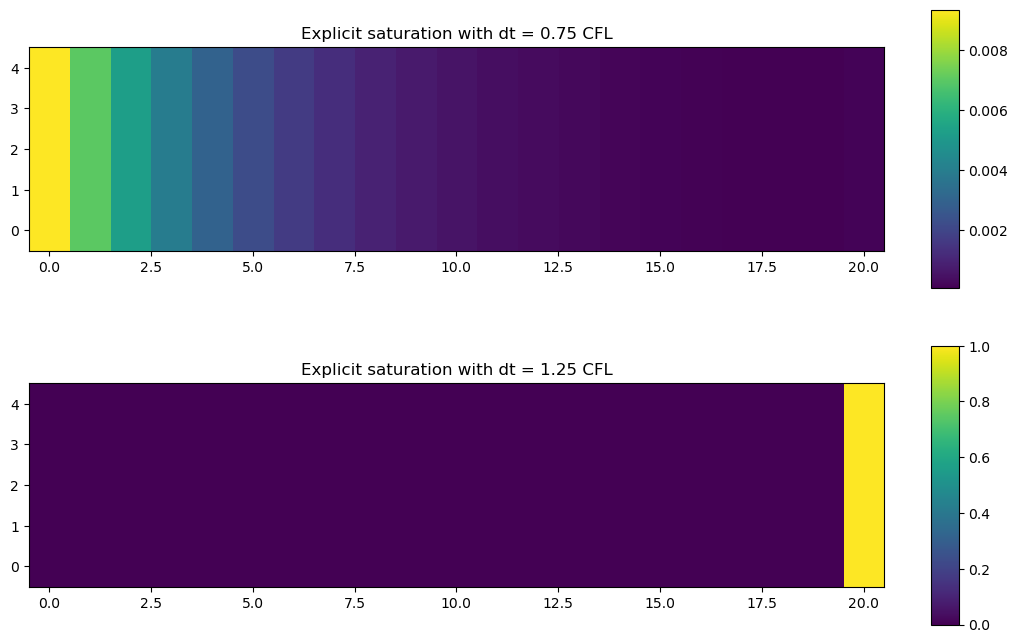

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

im = ax1.imshow(S_exp_under.reshape(21, 5).T)
ax1.invert_yaxis()
ax1.set_title("Explicit saturation with dt = 0.75 CFL")
plt.colorbar(im, ax=ax1, aspect=10, fraction=0.03)

im2 = ax2.imshow(S_exp_above.reshape(21, 5).T)
ax2.invert_yaxis()
ax2.set_title("Explicit saturation with dt = 1.25 CFL")

plt.colorbar(im2, ax=ax2, aspect=10, fraction=0.03)
plt.show()

### IMS: Implicit Saturation solver

Solves the saturation problem implicitly, requires Newton's method to solve the non-linear system of equation. Unconditionally stable. 

In [22]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# Pressure initialization: Initial pressure guess, does matter a lot ! 
P = np.full(grid.nb_cells, 100.0e5)
dt = 1.
S_imp, dt, step = implicit_saturation_solver(
                        grid=grid,
                        phi=phi,
                        T=T, 
                        P=P,
                        S=S,
                        Pb=Pb,
                        Sb_dict=Sb_dict,
                        dt=dt,
                        mu_g=mu_g,
                        wells=[],
                    )

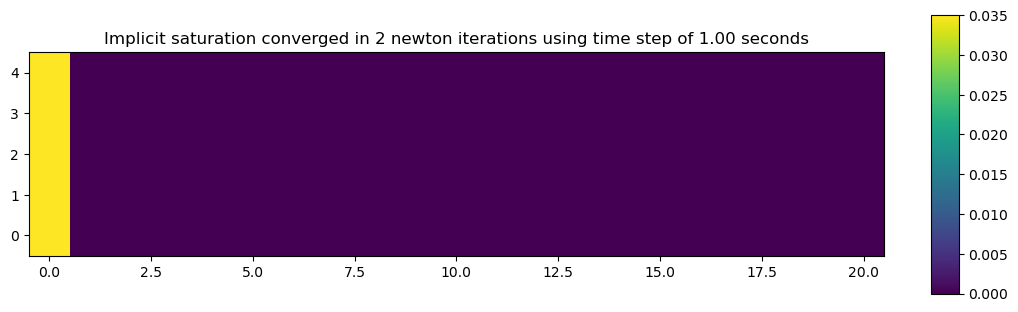

In [23]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

im = ax1.imshow(S_imp.reshape(21, 5).T)
ax1.invert_yaxis()
ax1.set_title(f"Implicit saturation converged in {step} newton iterations using time step of {dt:.2f} seconds")
plt.colorbar(im, ax=ax1, aspect=10, fraction=0.03)

plt.show()

### IMPIMS

In [24]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# timestep in seconds 
dt = 1.25 * cfl_IMPES
S_imp, dt, step = implicit_saturation_solver(
                        grid=grid,
                        phi=phi,
                        T=T, 
                        P=Pimp,
                        S=S,
                        Pb=Pb,
                        Sb_dict=Sb_dict,
                        dt=dt,
                        mu_g=mu_g,
                        wells=[],
                        max_newton_iter=20
                    )

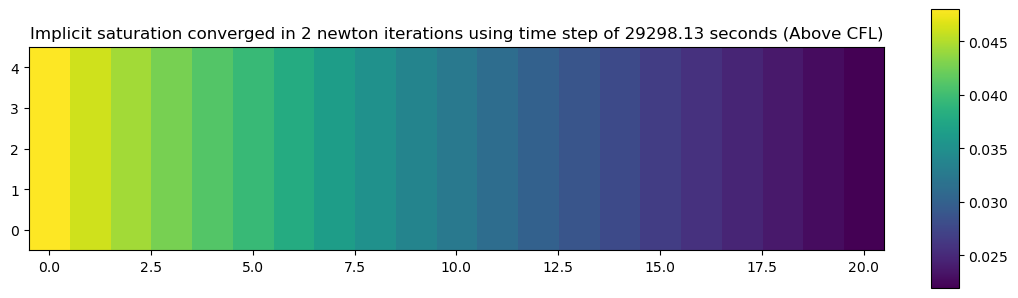

In [25]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

im = ax1.imshow(S_imp.reshape(21, 5).T)
ax1.invert_yaxis()
ax1.set_title(f"Implicit saturation converged in {step} newton iterations using time step of {dt:.2f} seconds (Above CFL)")
plt.colorbar(im, ax=ax1, aspect=10, fraction=0.03)

plt.show()

### SOLLS (Fully Implicit)

Solves simultaneously the pressure and saturation problems. Requires Newton's method to solve the non-linear system of equations, unconditionally stable. 
This scheme is the one mostly used in industrial softwares. 

In [26]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# Pressure initialization: Initial pressure guess, does matter a lot ! 
P = np.full(grid.nb_cells, 100.0e5)
dt = 5000.
P_solss, S_solss, dt, nb_newton, norm_dict = solss_solver.solss_newton_step(
                                        grid=grid,
                                        P_i=P,
                                        S_i=S,
                                        P_guess=P,
                                        S_guess=S,
                                        Pb=Pb,
                                        Sb_dict=Sb_dict,
                                        phi=phi,
                                        K=K,
                                        T=T,
                                        mu_g=mu_g,
                                        mu_w=mu_g,
                                        dt_init=dt,
                                        dt_min=1e-3,
                                        wells=[],
                                        max_newton_iter=20,
                                        eps=1e-6,
                                        kr_model=kr_model, 
                                )

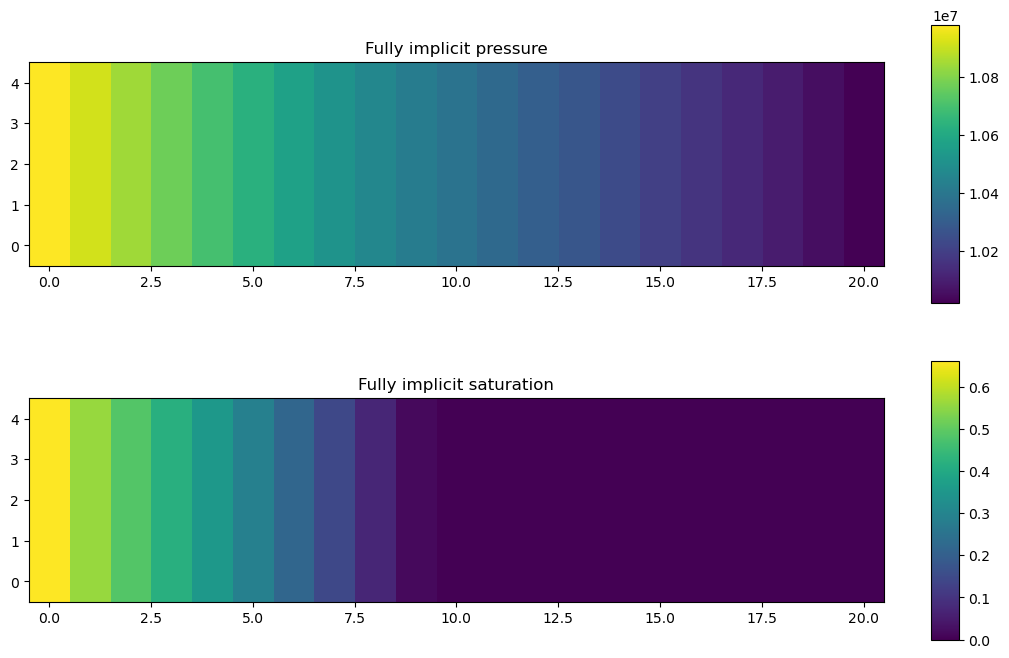

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

im = ax1.imshow(P_solss.reshape(21, 5).T)
ax1.invert_yaxis()
ax1.set_title("Fully implicit pressure")
plt.colorbar(im, ax=ax1, aspect=10, fraction=0.03)

im2 = ax2.imshow(S_solss.reshape(21, 5).T)
ax2.invert_yaxis()
ax2.set_title("Fully implicit saturation")

plt.colorbar(im2, ax=ax2, aspect=10, fraction=0.03)
plt.show()

## Run whole simulations
Now if we want to run an entire simulation requiring multiple steps of time, we call the related scheme 

In [28]:
from yads.numerics.schemes import impes, impims, solss

In [29]:
total_sim_time = 1000
dt = 100

### IMPES (Need Refactoring)

In [30]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# Pressure initialization: Initial pressure guess, does matter a lot ! 
P = np.full(grid.nb_cells, 100.0e5)

impes.impes_solver(
    grid=grid,
    P=P,
    S=S,
    Pb=Pb,
    Sb_dict=Sb_dict,
    phi=phi,
    K=K,
    mu_w=mu_w,
    mu_o=mu_g,
    total_sim_time=total_sim_time,
    dt_init=dt,
    wells = None,
)

CFL conditions not respected at step 0: 100 > 29.922498275313547
step: 0 done in 0.010239839553833008 seconds
step: 1 done in 0.008069276809692383 seconds
step: 2 done in 0.007407188415527344 seconds
step: 3 done in 0.007547855377197266 seconds
step: 4 done in 0.008421897888183594 seconds
step: 5 done in 0.007279872894287109 seconds
step: 6 done in 0.013298749923706055 seconds
step: 7 done in 0.00760197639465332 seconds
step: 8 done in 0.008277654647827148 seconds
step: 9 done in 0.008327007293701172 seconds
step: 10 done in 0.01067209243774414 seconds
step: 11 done in 0.009546041488647461 seconds
step: 12 done in 0.008581161499023438 seconds
step: 13 done in 0.009206056594848633 seconds
step: 14 done in 0.010107994079589844 seconds
step: 15 done in 0.00919198989868164 seconds
step: 16 done in 0.011222124099731445 seconds
step: 17 done in 0.010950088500976562 seconds
step: 18 done in 0.007183074951171875 seconds
step: 19 done in 0.015226125717163086 seconds
step: 20 done in 0.014193058

### IMPIMS

In [39]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# Pressure initialization: Initial pressure guess, does matter a lot ! 
P = np.full(grid.nb_cells, 100.0e5)

newton_list, dt_list = impims.impims_solver(
            grid=grid,
            P=P,
            S=S,
            Pb=Pb,
            Sb_dict=Sb_dict,
            phi=phi,
            K=K,
            mu_w=mu_w,
            mu_g=mu_g,
            total_sim_time=total_sim_time,
            dt_init=dt,
            wells = None,
            kr_model=kr_model,
            max_newton_iter=20
        )

step: 1 done in 0.027817964553833008 seconds
total sim time: 1e+01%
step: 2 done in 0.010595083236694336 seconds
total sim time: 2e+01%
step: 3 done in 0.01413106918334961 seconds
total sim time: 3e+01%
step: 4 done in 0.01080012321472168 seconds
total sim time: 4e+01%
step: 5 done in 0.005834102630615234 seconds
total sim time: 5e+01%
step: 6 done in 0.011600971221923828 seconds
total sim time: 6e+01%
step: 7 done in 0.007353782653808594 seconds
total sim time: 7e+01%
step: 8 done in 0.013663053512573242 seconds
total sim time: 8e+01%
step: 9 done in 0.0050890445709228516 seconds
total sim time: 9e+01%
step: 10 done in 0.008902311325073242 seconds
total sim time: 1e+02%
total simulation time:  1000.0
--- 0.11947321891784668 seconds ---


In [40]:
newton_list

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

### Fully Implicit

In [41]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# Pressure initialization: Initial pressure guess, does matter a lot ! 
P = np.full(grid.nb_cells, 100.0e5)

newton_list, dt_list = solss(
        grid=grid,
        P=P,
        S=S,
        Pb=Pb,
        Sb_dict=Sb_dict,
        phi=phi,
        K=K,
        mu_g=mu_g,
        mu_w=mu_w,
        dt_init=dt,
        total_sim_time=total_sim_time,
        kr_model=kr_model,
        wells=[],
        max_newton_iter=20,
        eps=1e-6
    )

step: 1 done in 0.0613 seconds with dt=1.000E+02s
step: 2 done in 0.0068 seconds with dt=1.000E+02s
step: 3 done in 0.0047 seconds with dt=1.000E+02s
step: 4 done in 0.0059 seconds with dt=1.000E+02s
step: 5 done in 0.0079 seconds with dt=1.000E+02s
step: 6 done in 0.0093 seconds with dt=1.000E+02s
step: 7 done in 0.0038 seconds with dt=1.000E+02s
step: 8 done in 0.0036 seconds with dt=1.000E+02s
step: 9 done in 0.0063 seconds with dt=1.000E+02s
step: 10 done in 0.0076 seconds with dt=1.000E+02s
total simulation time:  1000.0
--- 0.12457895278930664 seconds ---


In [42]:
newton_list

[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]